In [4]:
import os
import matplotlib.pyplot as plt
import json
import imageio as iio
from threading import Thread
import numpy as np
import tensorflow as tf

%matplotlib inline

In [5]:
mainPath = "../hand_labels"
trainDataPath = mainPath + "/manual_train"
testDataPath = mainPath + "/manual_test"
baseShape = (1080, 1920, 3)
#What i nedd from the data AKA clasees
#1 - hand_box_center
# 2- is_left
# 3 - hand_pts

In [6]:
b = array = np.zeros((576, 720, 3))
print(b.shape == (576, 720, 3))

True


In [91]:
shapes = []
images_samples = []
images_json = []

files = os.listdir(trainDataPath)
for i in range(500,len(files)) : 
    fileName = files[i]
    f = os.path.join(trainDataPath, fileName)
    if(fileName.rpartition(".")[2] != "json"):
            img = np.array(iio.v3.imread(f))
            img_shape = img.shape 
            jsonPath = os.path.join(trainDataPath, fileName).rsplit('.', 1)
            if img_shape not in shapes: (shapes.append(img_shape),
                images_samples.append(img),
                images_json.append(json.load(
                    open(jsonPath[0]  + "." + "json")
                )))

In [92]:
print(images_json[imgIndex])

{'mpii_image': '046644709.jpg', 'mpii_annorect_idx': 0, 'mpii_body_pts': [[1029.0, 612.0, 0.0], [1018.0, 370.0, 0.0], [1016.6284790039062, 346.456298828125, 0.0], [1007.3715209960938, 187.543701171875, 0.0], [1086.0, 950.0, 0.0], [1033.0, 798.0, 1.0], [1048.0, 607.0, 0.0], [1009.0, 616.0, 1.0], [973.0, 825.0, 1.0], [1009.0, 995.0, 0.0], [890.0, 234.0, 1.0], [976.0, 299.0, 0.0], [1057.0, 341.0, 0.0], [979.0, 398.0, 1.0], [890.0, 499.0, 1.0], [827.0, 443.0, 1.0]], 'hand_pts': [[827.0, 443.0, 1.0], [837.0792846679689, 426.60641479492193, 1.0], [841.4329223632811, 411.97525024414057, 1.0], [846.0587158203125, 404.93060302734375, 1.0], [833.5418701171876, 405.4725036621093, 1.0], [805.242919921875, 410.62051391601557, 1.0], [817.2155151367188, 407.36914062500006, 1.0], [829.1881713867189, 406.5562744140625, 1.0], [835.1744995117189, 411.7042846679688, 1.0], [798.9844360351564, 424.7097778320313, 1.0], [808.5081787109375, 416.3103942871093, 1.0], [820.4808349609376, 414.4137573242187, 1.0], 

(720, 960, 3)


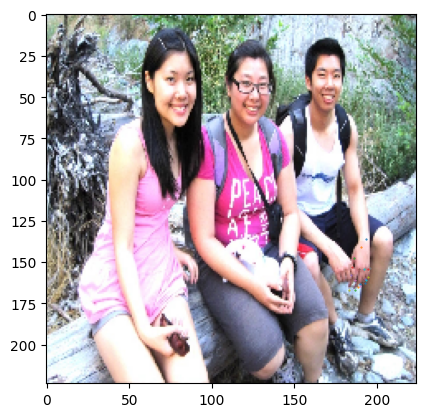

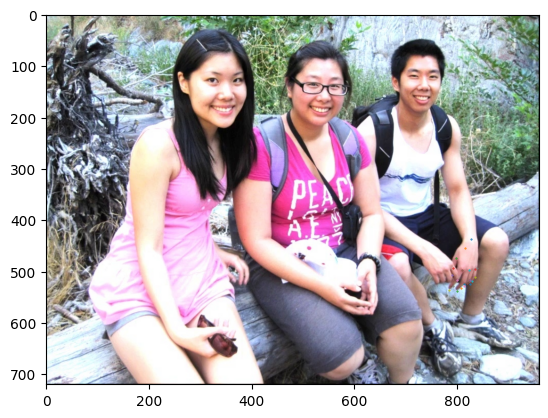

In [94]:
imgIndex = 6
img_now = tf.image.resize(images_samples[imgIndex].copy(),(224,224),method='nearest')
images_json_now = images_json[imgIndex].copy()["hand_pts"].copy()

org_shape = images_samples[imgIndex].shape
print(org_shape)
fig1, ax1 = plt.subplots()
ax1.imshow(img_now)
fig2, ax2 = plt.subplots()
ax2.imshow(images_samples[imgIndex])

for i in images_json_now:
    newDim = lambda ind,x :(224/org_shape[x]) * i[ind]
    
    ax1.plot(newDim(0,1),newDim(1,0),".",markersize=1)
    ax2.plot(i[0],i[1],".",markersize=1)

In [8]:
files = os.listdir(trainDataPath)
data = {}
for i in range(len(files)) :
    fileName = files[i]
    f = os.path.join(trainDataPath, fileName)
    if(fileName.rpartition(".")[2] != "json"):
        arr = np.array(iio.v3.imread(f))
        if(data.get(arr.shape) == None):
            data[arr.shape] = 0
        data[arr.shape] += 1
print(data)

{(720, 1280, 3): 326, (1080, 1920, 3): 531, (480, 654, 3): 4, (480, 848, 3): 2, (720, 1278, 3): 2, (1080, 1440, 3): 12, (1080, 1916, 3): 8, (480, 854, 3): 5, (720, 960, 3): 8, (1080, 1906, 3): 8, (576, 720, 3): 852, (300, 400, 3): 154}


In [3]:
def addData(startIndex,endIndex,labels,images,path) :
    files = os.listdir(path)
    for i in range(startIndex,endIndex) : 
        fileName = files[i]
        f = os.path.join(path, fileName)
        if(fileName.rpartition(".")[2] == "json"):
            fOPen = open(f)
            data = json.load(fOPen)
            fOPen.close()
            
            currentData = {}
            currentData["hand_box_center"] = data["hand_box_center"]
            currentData["is_left"] = data["is_left"]
            currentData["hand_pts"] = data["hand_pts"]

            labels.append(currentData)
        else:
            img = np.array(iio.v3.imread(f))
            img_shape = img.shape 

            get_padding_lenght = lambda current_index : (baseShape[current_index] - img_shape[current_index])

            img_after_padding = np.pad(img,pad_width=((0,get_padding_lenght(0)),
                                                       (0,get_padding_lenght(1)),
                                                        (0,0)))
                                                      
            images.append(img_after_padding) 

In [4]:
def getBaseData(path,threadCount,countInEachThread) :
    labels = []
    images = []
    threads = []
    
    for i in range(threadCount) :
        th = Thread(name=f"data {i}",target=addData, args=([i * countInEachThread, (i+1) * countInEachThread ,
                                                           labels ,images ,path]))
        th.start()
        threads.append(th)

    for thread in threads : 
        thread.join()
        
    return np.array(labels),np.array(images)

In [5]:
def get_train_data(half_data=True):
    #3824 files on 16 thread with 239 each
    countInEachThread = 16 
    threadCount = 239
    if(half_data) :
        countInEachThread = 478 
        threadCount = 4
    # countInEachThread = 4 
    # threadCount = 5
    labels,images = getBaseData(trainDataPath,threadCount,countInEachThread)
    training_labels,training_images = labels,images

    return training_labels,training_images
    
def get_test_data(half_data=True):
     #1692 files on 16 thread with 239 each
    countInEachThread = 12 
    threadCount = 141
    if (half_data):
        countInEachThread = 94
        threadCount = 9
         
    labels,images = getBaseData(testDataPath,threadCount,countInEachThread)
    test_labels,test_images = labels,images
    return test_labels,test_images

In [6]:
# training_labels,training_images = get_train_data()
test_labels,test_images = get_test_data()

# print(len(training_labels),len(training_images),training_images.shape)
print(len(test_labels),len(test_images),test_images.shape)

423 423 (423, 1080, 1920, 3)


In [7]:
imgIndex = 52
plt.imshow(training_images[imgIndex])
for i in training_labels[imgIndex]["hand_pts"]:
    plt.plot(i[0],i[1],".",markersize=1)

NameError: name 'training_images' is not defined